In [1]:
# importing the libraries

import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
import pylab
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from util5 import read_data_dual_input # image and patch
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
import random

Using TensorFlow backend.


In [4]:
# inputs

# train

csvPath = 'OLD2/Master2M.csv'
imagePath = '/home/maalidoost/OLD2/Seg2M'
patchPath = '/home/maalidoost/OLD2/Seg2Mask'

inputSize = (224,224)
patchSize = (64, 64)
split_ratio = 0.2
batch_size = 16
learning_rate = 1e-6
epoch_size = 2
nodes = 1024 # number of nodes for the fc layer
drop_out = 0.5 # after the fc layer

input_1 = (224, 224, 3)
input_2 = (64, 64, 3)

# test

test_dir = '/home/maalidoost/Seg2'
csvTest = 'Master2.csv'

Labels loaded: 16 positive,15 negatve.
Images loaded: 31; Masks loaded: 31
Multiple inputs training data preparation:

train_images: (144, 224, 224, 3)
train_patches: (144, 64, 64, 3)
train_labels: (144,)
val_images: (42, 224, 224, 3)
val_patches: (42, 64, 64, 3)
val_labels: (42,)

making the model for the first input

making the model for the second input

Epoch 1/2
9/9 [==============================] - 5s 528ms/step - loss: 0.7945 - acc: 0.5069 - val_loss: 0.7450 - val_acc: 0.4048
Epoch 2/2
9/9 [==============================] - 2s 264ms/step - loss: 0.7381 - acc: 0.5556 - val_loss: 0.6921 - val_acc: 0.4762



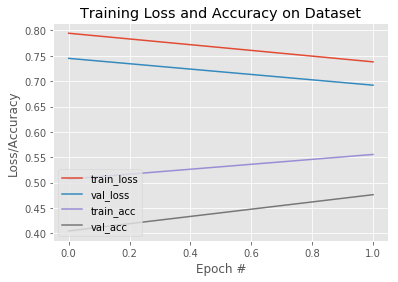

In [6]:
# preparing the data to train

random.seed(7)

train_images, train_patches, train_labels, val_images, val_patches, val_labels = \
read_data_dual_input(csvPath, imagePath, patchPath, inputSize, patchSize, split_ratio,
                     aug_rotate = 6, kfold = 1, outchannels = 3)
print("")
print('using multiple inputs')
print("")
print('train_images:', train_images.shape)
print('train_patches:', train_patches.shape) 
print('train_labels:', train_labels.shape)
print('val_images:', val_images.shape)
print('val_patches:', val_patches.shape) 
print('val_labels:', val_labels.shape)

print("")
print("making the model for the first input")

# using the pretrained model for training

conv_base_1 = VGG16(weights = 'imagenet', include_top = False, input_shape = input_1)

for layer in conv_base_1.layers:
    layer.name = layer.name + str("_1")

#conv_base_1.summary()

# Creating dictionary that maps layer names to the layers
#layer_dict = dict([(layer.name, layer) for layer in conv_base.layers])
# Getting output tensor of the last VGG layer that we want to include
#lay = layer_dict['block5_pool'].output
#print (lay)

for layer in conv_base_1.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers

#for layer in conv_base_1.layers:
#    print(layer, layer.trainable)

inp_1 = layers.Input(shape = input_1)
conv_base_out_1 = conv_base_1(inp_1)
flat_1 = layers.Flatten()(conv_base_out_1)
#print(flat_1)

print("")
print("making the model for the second input")
# using the pretrained model for training

#conv_base_2 = VGG16(weights = 'imagenet', include_top = False, input_shape = input_2)
conv_base_2 = VGG19(weights = 'imagenet', include_top = False, input_shape = input_2)
#conv_base_2 = ResNet50(weights = 'imagenet', include_top = False, input_shape = input_2)

for layer in conv_base_2.layers:
    layer.name = layer.name + str("_2")

#conv_base_2.summary()

# Creating dictionary that maps layer names to the layers
#layer_dict = dict([(layer.name, layer) for layer in conv_base.layers])
# Getting output tensor of the last VGG layer that we want to include
#lay = layer_dict['block5_pool'].output
#print (lay)

for layer in conv_base_2.layers[:-5]:
    layer.trainable = False

# Check the trainable status of the individual layers

#for layer in conv_base_2.layers:
#    print(layer, layer.trainable)

inp_2 = layers.Input(shape = input_2)
conv_base_out_2 = conv_base_2(inp_2)
flat_2 = layers.Flatten()(conv_base_out_2)
#print(flat_2)

# making the FC layers of the model

concat = layers.merge.concatenate([flat_1, flat_2])
dense1 = layers.Dense(nodes, activation = 'relu')(concat)
dense1 = layers.Dropout(drop_out)(dense1)
output = layers.Dense(1, activation= 'sigmoid')(dense1)

# creating the model with two inputs

model = models.Model(inputs = [inp_1, inp_2], outputs = output)
#print(model.summary())

# plotting the model graph

plot_model(model, to_file='multiple_inputs.png')

# compiling the model

model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=learning_rate), metrics=['acc'])

# data augmentation

train_datagen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

#val_datagen = ImageDataGenerator(rescale=1./255)

# training the model

print("")
H = model.fit_generator(
        train_datagen.flow([train_images, train_patches], train_labels, batch_size = batch_size),
        steps_per_epoch= len(train_images) // batch_size,
        epochs = epoch_size,
        validation_data = ([val_images, val_patches], val_labels),
        validation_steps = len(val_images) // batch_size)

# plotting the training loss and accuracy

print("")
plt.style.use("ggplot")
plt.figure()
N = epoch_size
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

# saving the model

model.save_weights('model_weights_lung_pro_multiple.h5')
model.save('model_lung_pro_multiple.h5')

In [7]:
# testing the model

# loading the model

model = load_model('model_lung_pro_2.h5')
#model.summary()

# getting X and y for testing

file_list2 = os.listdir(test_dir)
test_imgs = [test_dir + "/" + "{}".format(i) for i in file_list2]
#print("No. of test images = ", len(test_imgs))

X_test = []
IMG_SIZE = 224
for image in test_imgs:
    X_test.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC))

X_test = np.array(X_test)
X_test = X_test/255.0
print("shape of X_test:", X_test.shape)

df = pandas.read_csv(csvTest)
#print('shape of the dataframe:', df.shape)
#print(df.head(2))

na = df.loc[:,'File']
la = df.loc[:,'Progression']
na = np.array(na)
la = np.array(la)
I = np.argsort(na)
na = na[I]
la = la[I]
y_test = la

sns.set(rc={'figure.figsize':(5,4)})
sns.countplot (y_test)
plt.title("Labels")
print ("shape of y_test:", y_test.shape)

# model prediction

preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
predictions_test = preds_test_t [:, 0]
print("")

print("Predicted labels:", predictions_test)
print("")
print("True labels:", y_test)
print("")

com = np.isclose(predictions_test, y_test.T)
print (com)

#true_prediction_number = 1 * (com == 'True')
#print(true_prediction_number)

cm = confusion_matrix(y_test, predictions_test)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

OSError: Unable to open file (Unable to open file: name = 'model_lung_pro_2.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)